In [30]:
%run SetUp.ipynb

In [3]:
angles_from_vqe = [0.1781, 0.10]

## Define VQE form

In [19]:
# VQE
# "state" is the state PYP acts on. Implementing this way to not have to generate an entire matrix and save running time. 
# odd layer theta0*POYPO theta1*P1YP1 then even layer

def PYP(angle1,angle2, nq,state):
    n_sets = int(nq/2)
    for mm in range(n_sets):
        bb,cc,dd = (2*mm+1)%nq,(2*mm+2)%nq,(2*mm+3)%nq
        state = sp.sparse.linalg.expm_multiply(-1j * angle1 * pad_op(bb,nq,proj0) @ pad_op(cc,nq,y) @ pad_op(dd,nq,proj0),state) 
        state = sp.sparse.linalg.expm_multiply(-1j * angle2 * pad_op(bb,nq,proj1) @ pad_op(cc,nq,y) @ pad_op(dd,nq,proj1),state)
    for m in range(n_sets):
        aa,bb,cc = (2*m)%nq,(2*m+1)%nq,(2*m+2)%nq
        state =  sp.sparse.linalg.expm_multiply(-1j * angle1 * pad_op(aa,nq,proj0) @ pad_op(bb,nq,y) @ pad_op(cc,nq,proj0),state)
        state =  sp.sparse.linalg.expm_multiply(-1j * angle2 * pad_op(aa,nq,proj1) @ pad_op(bb,nq,y) @ pad_op(cc,nq,proj1),state)
    return state


# Classical Calculation 20 qubits

In [2]:
nQQ = 20

In [1]:
import h5py

with h5py.File('/Users/zhiyaoli/IQuS Dropbox/Zhiyao Li/String Breaking/Data/eigenstates20.h5', 'r') as f:
    data = f['Dataset1'][:]
    
    
real_part = data[-1]["Re"]
imag_part = data[-1]["Im"]
numerical_vacuum = real_part + 1j * imag_part

In [15]:

# Generate Fake Vacuum
def fake_vac(nq):
    return sp.sparse.csr_array(ft.reduce(sp.sparse.kron, [[1.,0.]]* nq).toarray()).transpose()


In [16]:

# Turn on 3 links in the middle
def activate(init,nq): # init is a function of nq, init(nq) is a state
    if nq <= 5: raise Exception (" Size of system too small. Operate on number of qubits >= 6")
    loc = (nq-5) // 2
    P0XXXP0 = math.pi/2* ft.reduce(sp.sparse.kron,[proj0,x,x,x,proj0])
    act_mat =ft.reduce(sp.sparse.kron, [sp.sparse.identity(2**(loc)),P0XXXP0,sp.sparse.identity(2**(nq-loc-5))]) 
    return sp.sparse.linalg.expm_multiply(-1j * act_mat,init(nq))
    
# Unitary evolution on any initial with angles found in VQE1 to establish true vaccum
# this is currently very slow.

def true_vac(state,nq):
    return apply_vqe_form(angles_from_vqe,nq,state)

In [20]:

# Initialize State
vacuum = np.reshape(PYP(-0.17939731, -0.10569839,nQ,fake_vac(nQQ)).toarray(),-1)
initial = np.reshape(PYP(-0.17939731, -0.10569839,nQ,activate(fake_vac,nQQ)).toarray(),-1)

In [33]:
def plot_E_per_site(state,nq):      # state is a basic array
    E_exps = []
    for loc in range(nq):
        E_exps += [(np.real(state.conj().T @ He_persite_scipy(nq,g,loc) @ state))] # Should be CT(state).H.state
    plt.plot(list(range(nq)), E_exps,'b.',linestyle = "-", label = 'Electric Hamiltonian Expectation Value')
    return E_exps

[0.04775942400818194,
 0.044783482878300904,
 0.04775942400818185,
 0.04478348287830145,
 0.04775942400818276,
 0.044783482878301466,
 0.047759424008182734,
 0.04478348287830148,
 0.047759424008182706,
 0.0447834828783015,
 0.047759424008182644,
 0.04478348287830151,
 0.04775942400818274,
 0.044783482878301556,
 0.047759424008182644,
 0.04478348287830144,
 0.04775942400818263,
 0.04478348287830141,
 0.04775942400818201,
 0.04478348287830092]

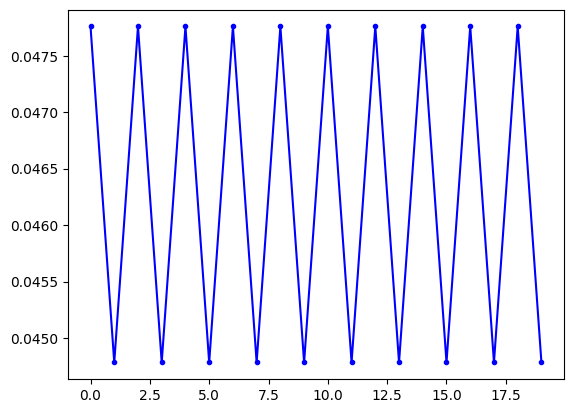

In [27]:
plot_E_per_site(vacuum,nQQ)

In [28]:
Hf = Hfull(nQQ,m,g).to_matrix(sparse = True)

In [34]:
# check vacuum propagation
# this is not Trotterized

ts = np.arange(0, 10, 0.8) # iffy on where to start and where to stop

exp_val = []
for i in ts:
    final_vacuum = sp.sparse.linalg.expm_multiply(-1j * Hf * i,vacuum)
    exp_val.append(overlap(final_vacuum,vacuum))


KeyboardInterrupt: 

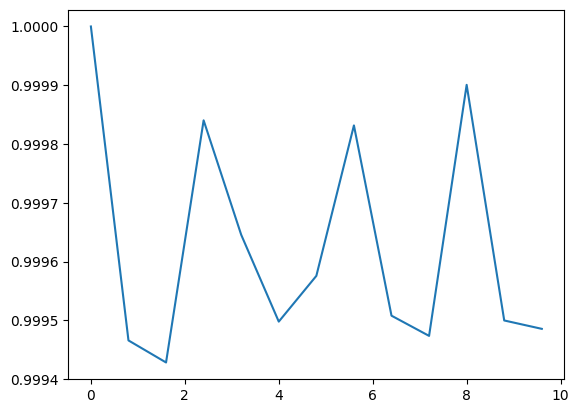

In [31]:
# Check vacuum evolution

plt.plot(ts,exp_val)

[0.047759424008182956,
 0.04478348287830176,
 0.04775942400818302,
 0.04478348287830173,
 0.04775942400818304,
 0.04478348287830174,
 0.047759424008182984,
 0.0005315913282299702,
 1.4999999999999953,
 1.48330409110025,
 1.4999999999999953,
 0.0005315913282299699,
 0.04775942400818298,
 0.04478348287830175,
 0.0477594240081829,
 0.04478348287830177,
 0.0477594240081829,
 0.0447834828783018,
 0.04775942400818301,
 0.04478348287830178]

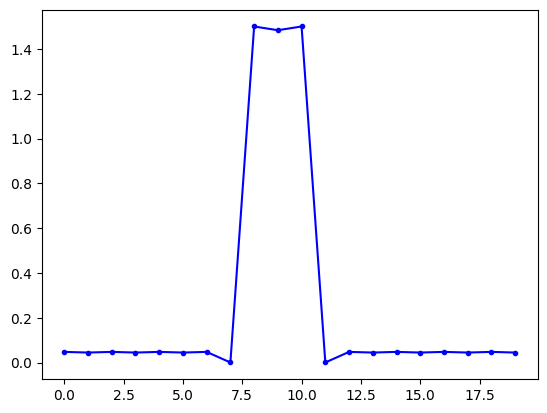

In [35]:
plot_E_per_site(initial,nQQ)

In [37]:
sp.linalg.norm(initial)

1.0000000000000004

In [ ]:
ts = np.arange(0, 10, 0.8) # iffy on where to start and where to stop
sites = np.arange(0, nQQ, 1) # iffy on where to start and where to stop

Data = []
for i in ts:
    final_state = sp.sparse.linalg.expm_multiply(-1j * Hf * i,initial)
    E_exps = []
    for loc in sites:
        E_exps += [(np.real(final_state.conj().T @ He_persite_scipy(nQQ,g,loc) @ final_state))] # Should be CT(state).H.state
    Data.append(E_exps)


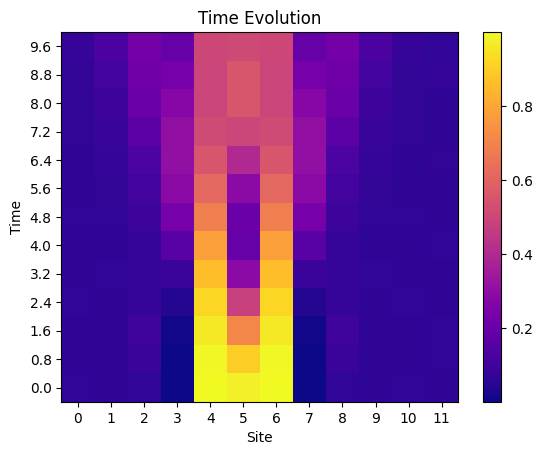

In [19]:
plt.pcolormesh(sites, ts, Data)
plt.colorbar()
plt.set_cmap('plasma')
# plt.clim(0.9729,0.99)
plt.xticks(sites)
plt.yticks(ts)
plt.xlabel("Site")
plt.ylabel("Time")
plt.title("Time Evolution")
plt.show()

[0.06682322662754532,
 0.06719977057028925,
 0.09311235755584935,
 0.2507691504372701,
 0.6658823029060361,
 0.21756681687495882,
 0.6658823029060352,
 0.2507691504372703,
 0.0931123575558505,
 0.06719977057028935,
 0.06682322662754571,
 0.05859132277736817]

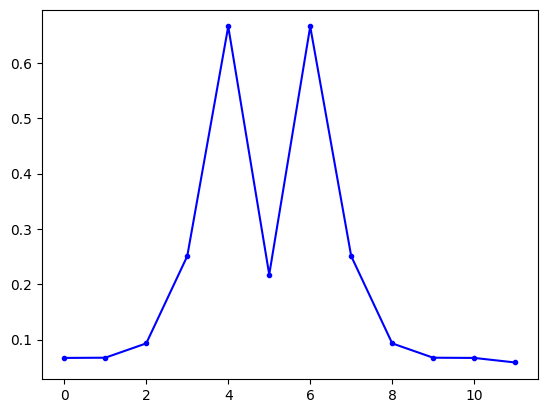

In [16]:
# Time evolution. Evolve with e^(-iHt)

final_state_3 = sp.sparse.linalg.expm_multiply(-1j * Hf * 5,initial)

plot_E_per_site(final_state_3,nQQ)

# Classical Calculation 16 qubits

In [17]:
nQ = 16

In [182]:
# Initialize State
vacuum16 = true_vac(fake_vac(nQ),nQ)
initial16 = true_vac(activate(fake_vac,nQ),nQ)

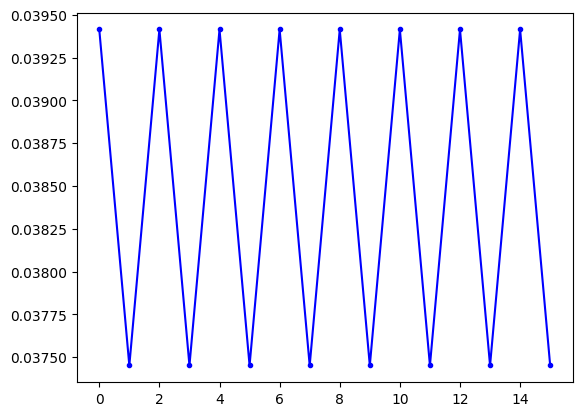

In [183]:
plot_E_per_site(vacuum16,nQ)

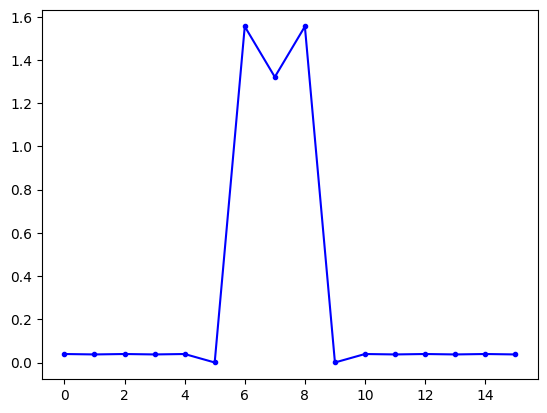

In [184]:
plot_E_per_site(initial16,nQ)

In [185]:
sp.sparse.linalg.norm(initial16)

0.9999999999999993

In [186]:
Hf16 = Hfull(nQ,m,g).to_matrix(sparse = True)

In [187]:
ts16 = np.arange(0, 20, 1) 
sites16 = np.arange(0, nQ, 1) 

Data16 = []
for i in ts16:
    final_state16 = sp.sparse.linalg.expm_multiply(-1j * Hf16 * i,initial16)
    E_exps16 = []
    for loc in sites16:
        E_exps16 += [(np.real(final_state16.conj().T @ He_persite_scipy(nQ,g,loc) @ final_state16)).toarray()[0][0]] 
    Data16.append(E_exps16)


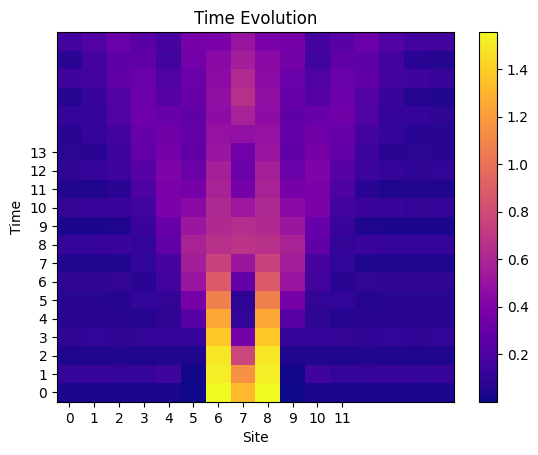

In [188]:
plt.pcolormesh(sites16, ts16, Data16)
plt.colorbar()
plt.set_cmap('plasma')
# plt.clim(0.9729,0.99)
plt.xticks(sites)
plt.yticks(ts)
plt.xlabel("Site")
plt.ylabel("Time")
plt.title("Time Evolution")
plt.show()

(0.0, 1.2)

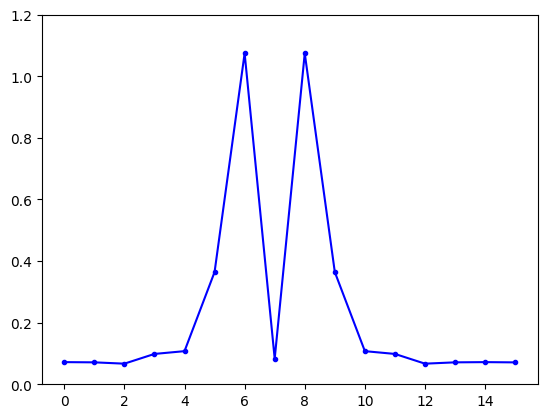

In [206]:
# Spot where the string broke

final_state_3 = sp.sparse.linalg.expm_multiply(-1j * Hf16 * 5,initial16)

plot_E_per_site(final_state_3,nQ)
plt.ylim(0,1.2)

(0.0, 1.2)

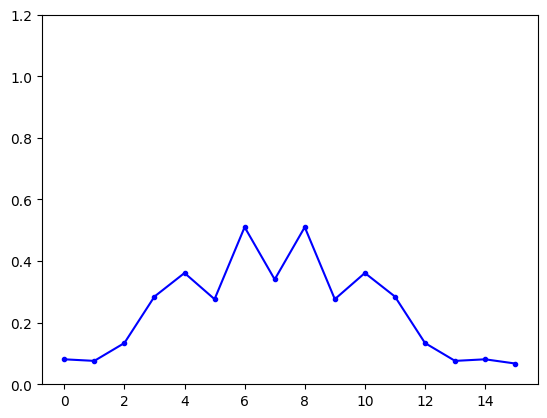

In [209]:
# Find where it starts touching the boundary to use for VQE for the evolved state

# can just run this line to generate the state used to train VQE. No need to redo time scan
final_state_3 = sp.sparse.linalg.expm_multiply(-1j * Hf16 * 13,initial16) 

plot_E_per_site(final_state_3,nQ)
plt.ylim(0,1.2)